# Introduction to Gaussian processes

## Background on JAX

The package that we will use for GPS, [tinygp](https://tinygp.readthedocs.io/en/stable/index.html), uses [JAX](https://docs.jax.dev/en/latest/index.html).
Jax is a package for machine learning, a bit like Pytorch and Tensorflow, which allows you to take advantage of GPUs and TPUs.

We will cover this type of package and their advantages during lessons on neural networks.
In addition to the calculation on GPUs, here are some other advantages of Jax:

- Similar interface to Numpy (`jax.numpy`)
- Calculation of gradients (`jax.grad`)
- Compilation _just in time_ (jit) (`jax.jit`)
- Automatic vectorization (`jax.vmap`)

Although Jax allows you to use GPUs, it also works on CPUs.
So you can install Jax on your computer following the [instructions d'installation](https://docs.jax.dev/en/latest/installation.html#).

To offer the features described above, JAX works differently from NUMPY in some respects.
These differences are presented in the tutorial, but here are the main lines:

- Jax expects "pure" functions, that is to say that always return the same value for the same entries and do not use the "global" context
- Tables cannot be changed directly. `a[0]=1.0` becomes `a=a.at[0].set(1.0) `([🔪 JAX - The Sharp Bits 🔪](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html))
- Random numbers are generated differently
- The default JAX accuracy for real numbers is 32bit (_single_). To use the precision 64Bit (_double_), you must add `jax.config.update(" jax_enable_x64", true) at the start of the code.

### Definition of a table and modification

Let's start by defining a table with Jax and checking that the _Double_ precision is well activated.

In [1]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
a = jnp.arange(5.0)
print("Test")
print(a)
print(a.dtype)

Test
[0. 1. 2. 3. 4.]
float64


We can see that modifying the table in place gives an error.

In [20]:
try:
    a[0] = 1
except TypeError as e:
    print("The following error occurred! \n")
    print(e)

The following error occurred! 

JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html


But that the property of `at` works as expected:

In [3]:
a = a.at[0].set(100.0)
a

Array([100.,   1.,   2.,   3.,   4.], dtype=float64)

### Function and differentiation

As with Numpy, you can define a function and display it in a graphic

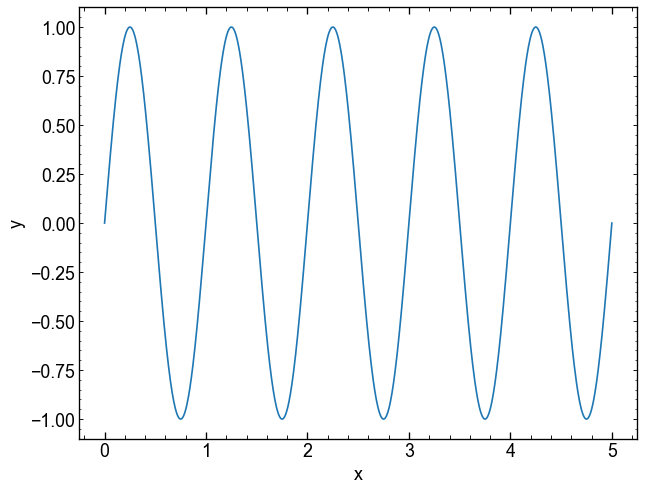

In [26]:
import matplotlib.pyplot as plt

def sinus(x, p):
    A, P, phi, off = p
    return A * jnp.sin(2 * jnp.pi * x / P - phi) + off

x = jnp.linspace(0, 5, num=1000)
params = [1.0, 1.0, 0.0, 0.0]
y = sinus(x, params)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

But as the function uses `jax.numpy`, you can get a gradient with `jax.grad`.
The `jax.grad` function only accepts functions that return a scalar.
It is here that the `JAX.VMAP` function becomes useful: it allows us to apply our gradient function on several `x`.


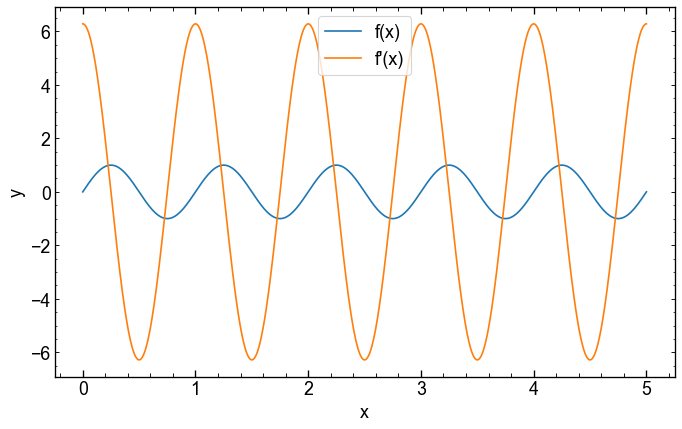

In [5]:
sinus_grad = jax.grad(sinus)  # Grad is done on the 1st argument by default
# We must tell VMAP on which arguments to operate:
# - axis 0 of the first argument
# - No axis of the 2nd argument
yp = jax.vmap(sinus_grad, in_axes=(0, None))(x, params)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label="f(x)")
plt.plot(x, yp,label="f'(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Compilation _just in time_ (jit)

We can also create a compiled version of our function with `jax.jit`.
During the first assessment, the function will be compiled and will be faster the following times.
You can use `%timeit` to test acceleration.
(Here, `block_Until_READ()` only ensures that JAX does not accelerate the evaluation with the _dispatch_ asynchronous).

In [6]:
# xtest = jnp.linspace (0.0, 10.0, number = 1_000_00)
# %Timeit Sinus (Xtet, Params) .Block_Until_Ready ()

If we use `jit`, we can speed up the function.

In [7]:
# sinus_jit = jax.jit (sinus)
# _ = sinus_jit (x, params) # we compile by performing for the first time
# %Timeit sinus_jit (xtest, params) .Block_Until_Ready () # We test the compiled version

In this case, the function is rather simple and the time saved is not huge.
On the other hand, the more complex our models, the useful the Jit compilation.

`Jax.jit` can also be used as a decorator on our function, for example

In [8]:
# @jax.jit
# Def sinus_jit_deco (x, p):
# A, p, phi, off = p
# Return a * jnp.in (2 * jnp.pi * x / p - phi) + off
# 
# _ = sinus_jit_deco (x, params) # we compile
# %Timeit sinus_jit_deco (xtest, params) .Block_Until_Ready () # We test the compiled version

These two methods are equivalent.

### Random numbers

With JAX, random numbers are generated a little differently from Numpy.
To operate on "pure" functions, the state of the random generator must be given in to the functions.
We do this using a "key", which can be divided as many times as necessary to generate new numbers.

In [9]:
key = jax.random.key(3051)
print(key)

Array((), dtype=key<fry>) overlaying:
[   0 3051]


However, a given key always generates the same value!!

In [10]:
print(jax.random.normal(key))
print(jax.random.normal(key))

-1.278167993100484
-1.278167993100484


To get new numbers, the key must be divided into a new `key` and a `subkey`.
We use the `subkey` to generate random numbers. The new `key` will be re-divided further in our code if necessary.

In [11]:
for _ in range(4):
    key, subkey = jax.random.split(key)
    print(jax.random.normal(subkey))

0.5328411343779211
0.33692105877614514
-1.152171978695814
-0.1276830979195066


**Exercise: Generate numbers taken from a normal 2D distribution centered at [0, 5] with the diagonal covariance matrix below. Display the samples on a 2D histogram (`Plt.hist2d` or` Corner.corner`).**

$$
C = \begin{matrix} 1 & 0 \\ 0 & 2 \end{matrix}
$$

(Multidimensional normal distribution is `jax.random.multivariat_normal` in JAX equivalent to Numpy).

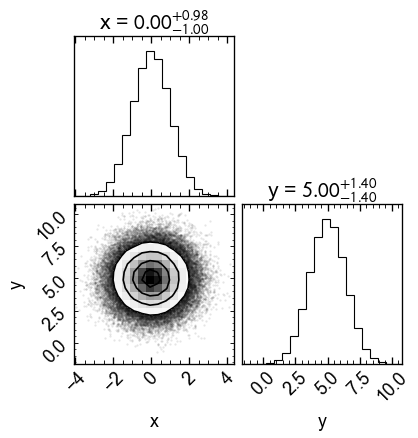

In [12]:
# TODO: Distribution

So! The above section covered the main things to know before using Jax.

## Gaussian process (implementation)

As seen in class, Gaussian processes (GPS) are mathematically quite simple.
It is therefore possible to implement them with `NUMPY` or` JAX.NUMPY`.

The equations we need are given to slides 12, 15 and 23.

### Covariance function

Let's start by defining a square exponential covariance (_kernel_).

$$
K_{\mathrm{se}} (x_i, x_j, \{\lambda\}) = \exp {\left (- \frac{1}{2\lambda^2} \left | x_i - x_j \right |^2 \right)}
$$

**Implement the equation above and display the result for $ x_i $ between -5 and 5. Keep $x_j$ fixed at 0.**

**Use $\lambda = 1.0$ as the scale**

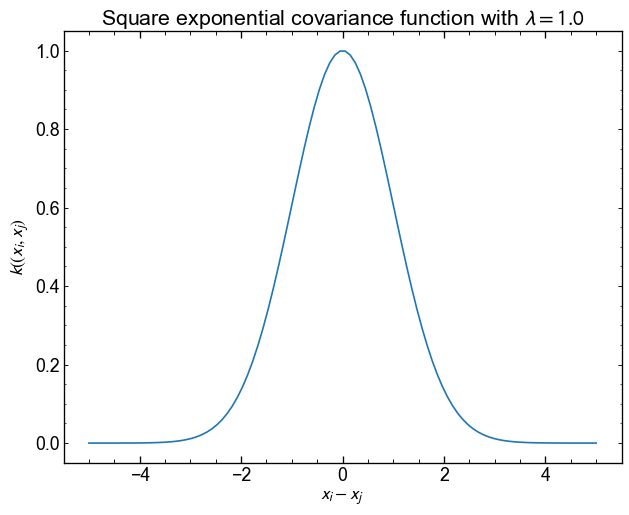

In [13]:
# TODO: KERNEL

plt.plot(xi - xj, k)
plt.xlabel("$x_i - x_j$")
plt.ylabel("$k((x_i,x_j)$")
plt.title(r"Square exponential covariance function with $\lambda=1.0$")
plt.show()

The function tells us that the points being close to each other are very correlated, but that beyond $ | x_i - x_j | > $ 4, the correlation is almost 0.

This correlation can be visualized in another way, using two vectors and looking at the point-point distance.

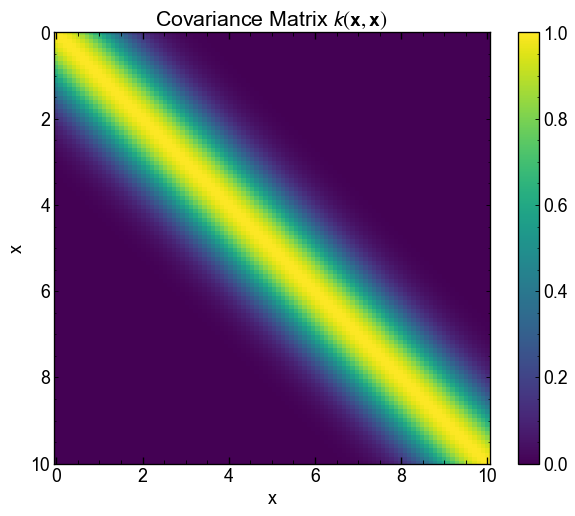

In [14]:
# TODO: Show the covariance matrix

### Prior distribution

As a GP is a Gaussian distribution on the functions, you can use the covariance matrix `Kmat` to generate evaluations $\mathbf{y} = F(\mathbf{x})$ taken from this distribution. Our mean function in this case will simply be a constant around 0.

**Use `jax.random.multivariat_normal()` to generate 5 samples of a distribution with an average of 0 and a covariance `kmat`.**
**Use the `method="svd"` argument to avoid digital errors.**

In [15]:
# TODO: Afficher la matrice

(5, 100)

The normal distribution at 100 dimension therefore returns us 5 vectors $ y $ evaluated at the values ​​of our function.
They can be displayed on the same graphic to see what type of functions the GP returns.

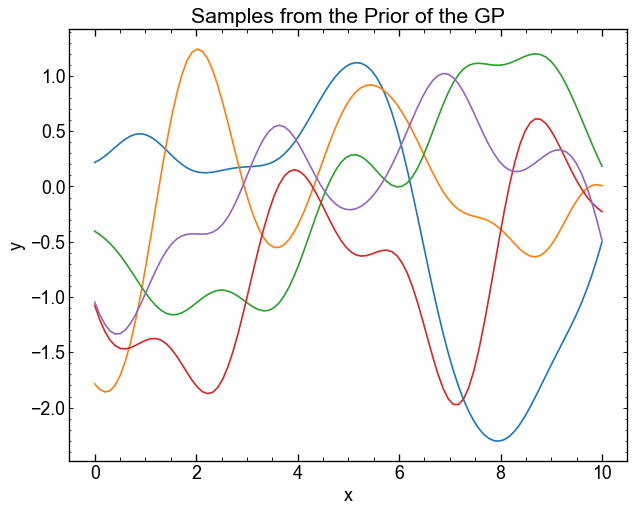

In [16]:
plt.plot(xi, gp_prior_samples.T)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Samples from the Prior of the GP")
plt.show()

These samples are taken from the **prior** distribution of the GP.
They are therefore not conditioned on any data, which makes them of not much use in practice.

### Posterior distribution (conditional)

We can simulate a few data points and use the equations of page 23 to obtain the posterior distribution of the GP conditioned on these observations.

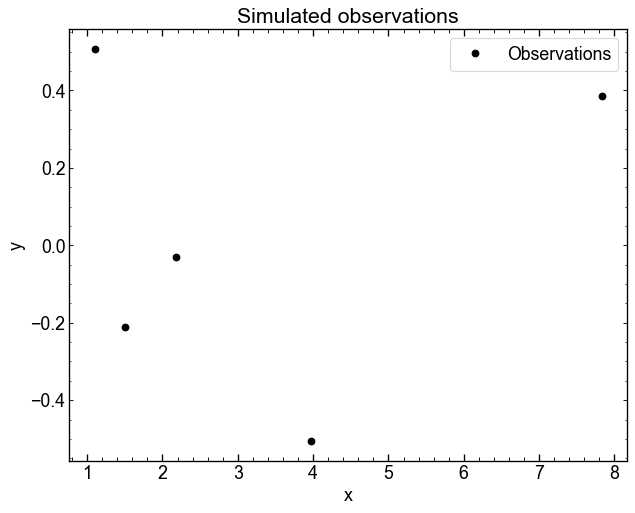

In [25]:
key, subkey1, subkey2 = jax.random.split(key, num=3)

x = jax.random.uniform(subkey1, shape=5, minval=0.5, maxval=9.0)
y = jax.random.normal(subkey2, shape=x.shape)
xt = jnp.linspace(0, 10, num=100)

plt.plot(x, y, "ko", label="Observations")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Simulated observations")
plt.legend()
plt.show()

Now that we have observations, we can generate samples from the posterior (conditional) distribution of the GP.
In these equations $x$ and $y$ denote observations vectors.
$x_\star $ is the point vector where we want to predict $y_\star$ (`xt` in the code).
Conditional distribution is given to page 23 of slides. We must first assess three covariance matrices

$$
K = k(x, x), k_\star = k(x, x_\star), k_{\star\star} = k(x_\star, x_\star).
$$

The conditional distribution of a GP is also a multidimensional Gaussian distribution, but its mean and its covariance are different from the a priori distribution:


$$
p(y_{\star}|y) = \mathcal{N}(f_\star, C_\star)
$$

where the mean is

$$
f_\star = m_\star + K_{\star}^T K^{-1} (y - m)
$$

and covariance

$$
C_\star = K_{\star\star} + K_{\star}^T K^{-1} K_{\star}.
$$

- **Use these equations to obtain the conditional distribution of the GP**. It is a normal distribution with several dimensions. The number of dimensions is the number of points in this case. The dimensions will be automatically informed by Numpy or Jax when you pass the average vector $ F_{\star}$ and the covariance matrix $C_{\star}$ in argument.
- **Once this distribution is obtained, display the average $f_{\star} $ superimposed on data.**
- **Also display an interval `Fill_between 'around the average using the standard deviation derived from $C_{\star}$** (index: variance is on the diagonal of $C_{\star}$).
- **Also display 5 samples from the a posteriori distribution of the GP**

<Details>
    
<Summary> Some hints (click to display) </ Summary>

1. Use `kernel (x [:, none], x [none ,:])` to easily vectorize the calculation of the covariance matrix
2. The function `JNP.linalg` and `jnp.diac` and the matrical multiplication operation command `@` will be useful.
3. To generate the samples, the Prior code can be reused, but you have to change the mean and covariance. Do not forget to re-divide the key!
</ details>

In [23]:
# TODO: Prédiction GP

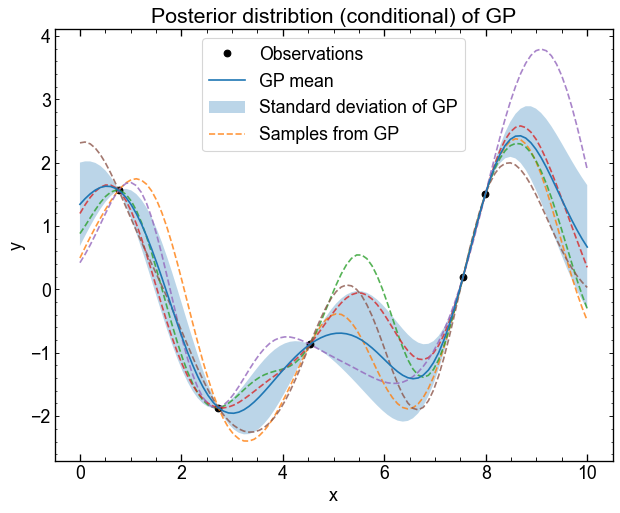

In [19]:
# TODO: Graphique GP

## Exploration

If you finish in advance, here are some suggestions to explore the GPS a little in more detail.
Nothing is compulsory.

Some suggestions:

- Try to modify the hyperparameter $\lambda$ How does that affect your results?
- Test other covariances function
- Add error bars to the observations. Add the corresponding variance to the diagonal of your matrix $k = K(x, x)$.
- implement the equation of the _likelihood_ (slide 28) for the GP and try to optimize the hyperparameter for this simple problem.
- How does the GP calculation time behave by adding observations?
- Try to implement the algorithm given to the slide 33. Cholesky factorization is implemented in [NumPy](https://numpy.org/doc/2.2/reference/generated/numpy.linalg.cholesky.html) and [JAX](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.linalg.cholesky.html).
- Start exploring the documentation of [tinygp](https://tinygp.readthedocs.io/en/stable/index.html).

**It is possible that you get digital instability in the first 4 questions. Do not waste too much time on this if this is the case. This is, among other things, why we will use TinyGP during the next course**.